# Netflix Movie Recommendation using SVD and Correlation

### Objective

Recommend best TV shows to users, based on their ratings given to movies and similar movies

### Data Info

Data file contains below columns:

Movie ID (as first line of each new movie record / file)
Customer ID
Rating (1 to 5)
Date they gave the ratings

There is another file contains the mapping of Movie ID to the movie background like name, year of release, etc

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

### Loading data

In [2]:
df1 = pd.read_csv('D:/St Clair/Semester 4/Capestone/Data/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


In [5]:
#df2 = pd.read_csv('D:/St Clair/Semester 4/Capestone/Data/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df3 = pd.read_csv('D:/St Clair/Semester 4/Capestone/Data/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
#df4 = pd.read_csv('D:/St Clair/Semester 4/Capestone/Data/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


#df2['Rating'] = df2['Rating'].astype(float)
#df3['Rating'] = df3['Rating'].astype(float)
#df4['Rating'] = df4['Rating'].astype(float)

#print('Dataset 2 shape: {}'.format(df2.shape))
#print('Dataset 3 shape: {}'.format(df3.shape))
#print('Dataset 4 shape: {}'.format(df4.shape))

In [3]:
df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


### Viewing data spread

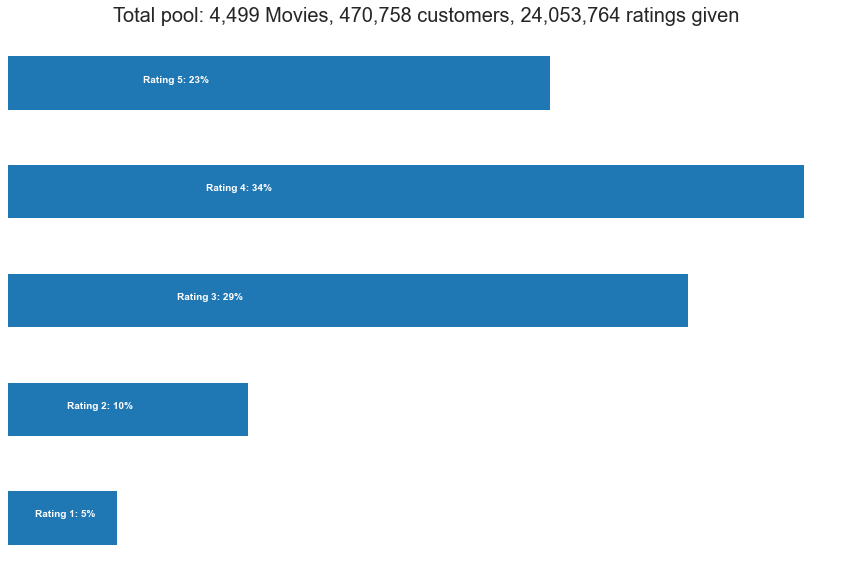

In [4]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

It is evident that the rating is generally high (>3). This might be because dissatisfied customers often just leave without leaving a review. We can keep in mind that low-rated films are typically really terrible.

### Data Cleaning

In [5]:
# Adding movieid column in the data

df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [6]:
#Removing rows with no ratings
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

C:\Users\umair\AppData\Local\Temp\ipykernel_13660\1547516286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


C:\Users\umair\AppData\Local\Temp\ipykernel_13660\1547516286.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


### Data Slicing

The data set is super huge.Reducing the data volumn by improving the data quality below:

* Remove movie with too less reviews (they are relatively not popular)
* Remove customer who give too less reviews (they are relatively less active)

In [7]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


Trimming the dataset

In [8]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
6932490   1299309     5.0      1384
13860273   400155     3.0      2660
20766530   466962     4.0      3923


### Data Mapping

Loading movie mapping file

In [9]:
df_title = pd.read_csv('D:/St Clair/Semester 4/Capestone/Data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


### Explortory Data Analysis

#### distribution of ratings

C:\Users\umair\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


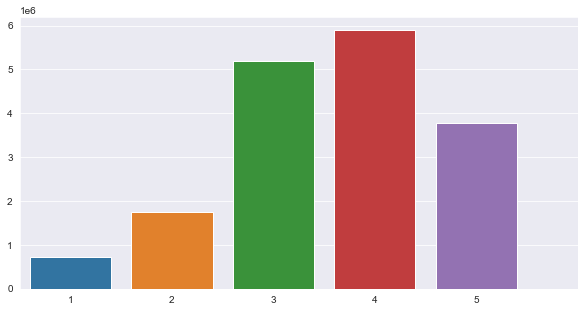

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

data = df['Rating'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
plt.xticks(ticks=[0,1,2,3,4,5]);

del fig, ax, data, x, y, xmin, xmax

#### distribution of number of ratings movies receive

C:\Users\umair\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


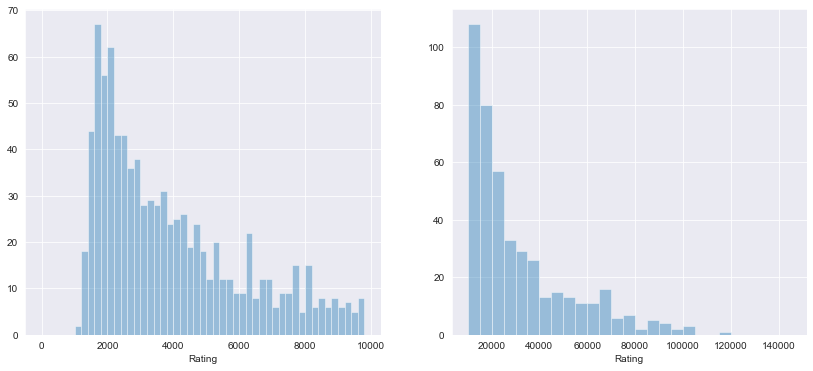

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie_Id')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0], bins=[i for i in range(0,10000,200)]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1], bins=[i for i in range(10000,150000,5000)]);

del fig, ax, data

### Recommendation Models

In [11]:
reader = Reader()

In [12]:
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)

In [13]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.84794851, 0.84810395, 0.84844858, 0.84773835, 0.84716671]),
 'test_mae': array([0.65866603, 0.65831372, 0.65869408, 0.65809018, 0.65769037]),
 'fit_time': (629.2011177539825,
  628.9811024665833,
  635.7395987510681,
  631.5418558120728,
  632.8007004261017),
 'test_time': (67.33727931976318,
  45.1406524181366,
  60.51682996749878,
  60.68778610229492,
  1334.5274941921234)}

### Bulding recommendations for user 785314

In [14]:
#Movies liked by user 785314
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57                                            Richard III
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
395                                         Captain Blood
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443 

In [15]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

Top 10 movies based on estimate score

In [16]:
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

        Year                                         Name  Estimate_Score
1799  2002.0                  An Evening With Kevin Smith        5.000000
3520  2000.0                           Coupling: Season 1        5.000000
4391  1993.0                             Army of Darkness        5.000000
3167  1987.0                    Evil Dead 2: Dead by Dawn        5.000000
2113  2002.0                                      Firefly        4.930140
3149  2000.0             Monty Python: The Life of Python        4.925484
1276  1988.0                          Red Dwarf: Series 3        4.906622
2018  2004.0                             Samurai Champloo        4.894130
3661  1994.0  House of Cards Trilogy II: To Play the King        4.768363
4053  1990.0     House of Cards Trilogy I: House of Cards        4.758910


### Recommend with Pearsons' R correlations

We calculate the linear correlation between review scores for all movie pairs using Pearson's R correlation, and then we list the top 10 films with the highest correlations:

In [19]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [17]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

### A recommendation for you if you like 'What the #$*! Do We Know!?'

In [20]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                     Name  count     mean
 1.000000               What the #$*! Do We Know!?  14910 3.189805
 0.505500                                Inu-Yasha   1883 4.554434
 0.452807 Captain Pantoja and the Special Services   1801 3.417546
 0.442354                Without a Trace: Season 1   2124 3.980226
 0.384179                     Yu-Gi-Oh!: The Movie   3173 3.331547
 0.383959                                 Scorched   2430 2.894239
 0.381173  All Creatures Great and Small: Series 1   2327 3.938118
 0.381112          As Time Goes By: Series 1 and 2   2249 4.164073
 0.373018                         Cowboys & Angels   2368 3.589527
 0.371981                           Biggie & Tupac   1866 3.019293


### X2: X-Men United:

In [26]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                  Name  count     mean
 1.000000                                      X2: X-Men United  98720 3.932202
 0.384550                              Batman Beyond: The Movie   2614 3.726855
 0.375967                                        Justice League   3591 3.710944
 0.361393                      Justice League: Justice on Trial   2961 3.718001
 0.338025                    Batman Beyond: Return of the Joker   3704 3.604752
 0.335256                                         Batman Begins  54922 4.236699
 0.328229                          Batman: Mask of the Phantasm   2823 3.767977
 0.327040 Batman: The Animated Series: Tales of the Dark Knight   2432 3.583059
 0.316666                       Dragon Ball Z: Super Android 13   2426 3.428689
 0.316166                              Mortal Kombat: The Movie   7633 3.165466
